# **<center> IMPLEMENTAZIONE </center>**


Scopo di questo progetto è quello di creare un modello per segmentare automaticamente lo stomaco e l'intestino nelle scansioni MRI, basandosi su un data set di queste scansioni per trovare soluzioni creative di deep learning che aiutino i pazienti oncologici a ricevere cure migliori.

Il processo di data mining è una pipeline che si compone delle seguenti fasi:

1. Data collection

2. Data preprocessing

3. Analytical processing

Seguiremo pertanto questa pipeline, suddividendo il notebook in **tre** parti principali e spiegando nel dettaglio le scelte fatte. 

# **<center> DATA COLLECTION </center>**

Questa fase serve a ... ed è di fondamentale importanza perchè buone scelte in questa fase possono avere un impatto significativo sull'intero processo di data mining. 

## Elenco importazioni

In [31]:
import os
import pandas as pd

## Definizione percorsi di base

In [32]:
BASE_DIR = "../BD-Image-Segmentation-Comp/" 
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TRAIN_CSV = os.path.join(BASE_DIR, 'train.csv')

Per gli algoritmi che prevedono casualità come, ad esempio, la costruzione dei batch, è necessaria la definizione di un seme che, per questioni di riproducibilità della run, abbiamo impostato ad un valore di default. 

In [33]:
SEED = 42

## Caricamento metadati

In questa fase importiamo il modello dal file `train.csv` al fine di ...

In [34]:
# df stands for dataframe
train_df = pd.read_csv(TRAIN_CSV)

# Stampiamo le prime 10 righe del dataframe di partenza
train_df.head(10)

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN
5,case123_day20_slice_0002,stomach,NaN
6,case123_day20_slice_0003,large_bowel,NaN
7,case123_day20_slice_0003,small_bowel,NaN
8,case123_day20_slice_0003,stomach,NaN
9,case123_day20_slice_0004,large_bowel,NaN


In [35]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115488 entries, 0 to 115487
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            115488 non-null  object
 1   class         115488 non-null  object
 2   segmentation  33913 non-null   object
dtypes: object(3)
memory usage: 2.6+ MB


Da una prima lettura, si evince che la maggior parte dei record non presenta alcuna segmentazione.

# **<center> DATA PREPROCESSING </center>**

Finita la parte di data collection, segue la fase di **data preprocessing**, in cui ...

Essa si compone dei seguenti passaggi:

1. Feature extraction
2. Data cleaning
3. Feature selection and trasformation

## FEATURE EXTRACTION

Ci troviamo davanti grandi volumi di dati grezzi ed abbiamo poche indicazioni su come questi dovrebbero essere trasformati in database di feature significative.

### Elenco importazioni

In [36]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor, Resize
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from glob import glob

### Preprocessing dei dati

Il primo passo consiste nell'estrarre gli id dei casi primari. Inoltre, dobbiamo trasformare le maschere di segmentazione in formato `str`, poiché i valori `NaN` saranno difficili da estrarre in altri modi.

Creiamo una funzione ad hoc per modellare ed estrarre alcune informazioni preliminari, chiamata `data_preprocessing` che, ricevuto in input il dataframe non processato, fornisce in output un dataframe in cui vengono estratte:

* la classe per la segmentazione

* il numero del caso clinico

* il giorno di valutazione del caso

* un identificativo per il frame della scansione.

In [37]:
def data_preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    
    df["segmentation"] = df["segmentation"].astype("str")
    
    df["case_id"] = df["id"].apply(lambda x: x.split("_")[0][4:]).astype("int")
    
    df["day_id"] = df["id"].apply(lambda x: x.split("_")[1][3:]).astype("int")
    
    df["slice_id"] = df["id"].apply(lambda x: x.split("_")[-1]).astype("int")
    
    return df

Il dataset appena formattato avrà quindi questa struttura:

In [38]:
train_df = data_preprocessing(train_df)

# Stampiamo le prime 10 righe del dataframe processato
train_df.head(10)

,id,class,segmentation,case_id,day_id,slice_id
0,case123_day20_slice_0001,large_bowel,nan,123,20,1
1,case123_day20_slice_0001,small_bowel,nan,123,20,1
2,case123_day20_slice_0001,stomach,nan,123,20,1
3,case123_day20_slice_0002,large_bowel,nan,123,20,2
4,case123_day20_slice_0002,small_bowel,nan,123,20,2
5,case123_day20_slice_0002,stomach,nan,123,20,2
6,case123_day20_slice_0003,large_bowel,nan,123,20,3
7,case123_day20_slice_0003,small_bowel,nan,123,20,3
8,case123_day20_slice_0003,stomach,nan,123,20,3
9,case123_day20_slice_0004,large_bowel,nan,123,20,4


Creiamo la funzione `estrai_file_da_id` che, forniti in input il percorso di partenza (da cui costruire la struttura delle cartelle) e l'id del dataframe (da cui ricavare il file), ritorna la stringa del percorso relativo al file ricavato.

In [39]:
def estrai_file_da_id(base_dir: str, case_id: str) -> str:
    
    # Ricaviamo la cartella del caso a partire dall'id salvato nel dataframe, formattato
    # sempre come "caseXYZ_dayDD_slice_SSSS"
    case_folder = case_id.split("_")[0]
    
    # In modo analogo, ricaviamo la cartella del giorno associato al caso appena estratto
    # e l'inizio del nome del file dello slice relativo all'id salvato nel dataframe
    day_folder = "_".join(case_id.split("_")[:2])
    file_starter = "_".join(case_id.split("_")[2:])
    
    # Generiamo, a partire dalle info estratte, il percorso delle scansioni 
    folder = os.path.join(base_dir, case_folder, day_folder, "scans")
    
    # Ricaviamo i file con un nome avente struttura simile (i.e. che iniziano nello stesso
    # modo)
    file = glob(f"{folder}/{file_starter}*")
    
    # Poiché glob genera una lista, siamo forzati a considerare il primo file in modo
    # esplicito, ma la glob restituirà sempre un solo file.
    file = file[0]
    
    return file

Adesso, avendo creato un modo per ottenere gli id delle varie immagini, possiamo procedere all'estrazione dei percorsi.

In [40]:
train_df["path"] = train_df["id"].apply(lambda x: estrai_file_da_id(TRAIN_DIR, x))
# Stampiamo le prime 10 righe del dataframe processato
train_df.head(10)

,id,class,segmentation,case_id,day_id,slice_id,path
0,case123_day20_slice_0001,large_bowel,nan,123,20,1,../BD-Image-Segmentation-Comp/train/case123/ca...
1,case123_day20_slice_0001,small_bowel,nan,123,20,1,../BD-Image-Segmentation-Comp/train/case123/ca...
2,case123_day20_slice_0001,stomach,nan,123,20,1,../BD-Image-Segmentation-Comp/train/case123/ca...
3,case123_day20_slice_0002,large_bowel,nan,123,20,2,../BD-Image-Segmentation-Comp/train/case123/ca...
4,case123_day20_slice_0002,small_bowel,nan,123,20,2,../BD-Image-Segmentation-Comp/train/case123/ca...
5,case123_day20_slice_0002,stomach,nan,123,20,2,../BD-Image-Segmentation-Comp/train/case123/ca...
6,case123_day20_slice_0003,large_bowel,nan,123,20,3,../BD-Image-Segmentation-Comp/train/case123/ca...
7,case123_day20_slice_0003,small_bowel,nan,123,20,3,../BD-Image-Segmentation-Comp/train/case123/ca...
8,case123_day20_slice_0003,stomach,nan,123,20,3,../BD-Image-Segmentation-Comp/train/case123/ca...
9,case123_day20_slice_0004,large_bowel,nan,123,20,4,../BD-Image-Segmentation-Comp/train/case123/ca...


A partire dai percorsi dei file estratti, possiamo accedere a nuove informazioni, come l'**altezza** e la **larghezza** delle immagini, che andiamo ad usare come ulteriori chiavi del dataframe.

In [41]:
train_df["height"] = train_df["path"].apply(lambda x: os.path.split(x)[-1].split("_")[2]).astype("int")
train_df["width"] = train_df["path"].apply(lambda x: os.path.split(x)[-1].split("_")[3]).astype("int")

train_df["height_px"] = train_df["path"].apply(lambda x: os.path.split(x)[-1].split("_")[4])
train_df["width_px"] = train_df["path"].apply(lambda x: os.path.split(x)[-1].split("_")[5].replace(".png", ""))

train_df.head(10)

,id,class,segmentation,case_id,day_id,slice_id,path,height,width,height_px,width_px
0,case123_day20_slice_0001,large_bowel,nan,123,20,1,../BD-Image-Segmentation-Comp/train/case123/ca...,266,266,1.50,1.50
1,case123_day20_slice_0001,small_bowel,nan,123,20,1,../BD-Image-Segmentation-Comp/train/case123/ca...,266,266,1.50,1.50
2,case123_day20_slice_0001,stomach,nan,123,20,1,../BD-Image-Segmentation-Comp/train/case123/ca...,266,266,1.50,1.50
3,case123_day20_slice_0002,large_bowel,nan,123,20,2,../BD-Image-Segmentation-Comp/train/case123/ca...,266,266,1.50,1.50
4,case123_day20_slice_0002,small_bowel,nan,123,20,2,../BD-Image-Segmentation-Comp/train/case123/ca...,266,266,1.50,1.50
5,case123_day20_slice_0002,stomach,nan,123,20,2,../BD-Image-Segmentation-Comp/train/case123/ca...,266,266,1.50,1.50
6,case123_day20_slice_0003,large_bowel,nan,123,20,3,../BD-Image-Segmentation-Comp/train/case123/ca...,266,266,1.50,1.50
7,case123_day20_slice_0003,small_bowel,nan,123,20,3,../BD-Image-Segmentation-Comp/train/case123/ca...,266,266,1.50,1.50
8,case123_day20_slice_0003,stomach,nan,123,20,3,../BD-Image-Segmentation-Comp/train/case123/ca...,266,266,1.50,1.50
9,case123_day20_slice_0004,large_bowel,nan,123,20,4,../BD-Image-Segmentation-Comp/train/case123/ca...,266,266,1.50,1.50


Per la fase di classificazione, piuttosto che usare delle categorie, preferiamo passare ad etichette numeriche, in modo da agevolarci in lavoro in seguito. 

In [42]:
class_names = train_df["class"].unique()

for index, label in enumerate(class_names):
    train_df["class"].replace(label, index, inplace = True)

train_df.head(10)

,id,class,segmentation,case_id,day_id,slice_id,path,height,width,height_px,width_px
0,case123_day20_slice_0001,0,nan,123,20,1,../BD-Image-Segmentation-Comp/train/case123/ca...,266,266,1.50,1.50
1,case123_day20_slice_0001,1,nan,123,20,1,../BD-Image-Segmentation-Comp/train/case123/ca...,266,266,1.50,1.50
2,case123_day20_slice_0001,2,nan,123,20,1,../BD-Image-Segmentation-Comp/train/case123/ca...,266,266,1.50,1.50
3,case123_day20_slice_0002,0,nan,123,20,2,../BD-Image-Segmentation-Comp/train/case123/ca...,266,266,1.50,1.50
4,case123_day20_slice_0002,1,nan,123,20,2,../BD-Image-Segmentation-Comp/train/case123/ca...,266,266,1.50,1.50
5,case123_day20_slice_0002,2,nan,123,20,2,../BD-Image-Segmentation-Comp/train/case123/ca...,266,266,1.50,1.50
6,case123_day20_slice_0003,0,nan,123,20,3,../BD-Image-Segmentation-Comp/train/case123/ca...,266,266,1.50,1.50
7,case123_day20_slice_0003,1,nan,123,20,3,../BD-Image-Segmentation-Comp/train/case123/ca...,266,266,1.50,1.50
8,case123_day20_slice_0003,2,nan,123,20,3,../BD-Image-Segmentation-Comp/train/case123/ca...,266,266,1.50,1.50
9,case123_day20_slice_0004,0,nan,123,20,4,../BD-Image-Segmentation-Comp/train/case123/ca...,266,266,1.50,1.50


Ordiniamo tutte le righe in ordine crescente di case_id, day_id e slice_id e distribuiamo di nuovo gli indici. 

In [43]:
train_df= train_df.sort_values(by=['case_id', 'day_id', 'slice_id'], ascending=True)

# distribuisco di nuovo gli indici del df
train_df = train_df.reset_index(drop=True)

train_df.head(10)

,id,class,segmentation,case_id,day_id,slice_id,path,height,width,height_px,width_px
0,case2_day1_slice_0001,0,nan,2,1,1,../BD-Image-Segmentation-Comp/train/case2/case...,266,266,1.50,1.50
1,case2_day1_slice_0001,1,nan,2,1,1,../BD-Image-Segmentation-Comp/train/case2/case...,266,266,1.50,1.50
2,case2_day1_slice_0001,2,nan,2,1,1,../BD-Image-Segmentation-Comp/train/case2/case...,266,266,1.50,1.50
3,case2_day1_slice_0002,0,nan,2,1,2,../BD-Image-Segmentation-Comp/train/case2/case...,266,266,1.50,1.50
4,case2_day1_slice_0002,1,nan,2,1,2,../BD-Image-Segmentation-Comp/train/case2/case...,266,266,1.50,1.50
5,case2_day1_slice_0002,2,nan,2,1,2,../BD-Image-Segmentation-Comp/train/case2/case...,266,266,1.50,1.50
6,case2_day1_slice_0003,0,nan,2,1,3,../BD-Image-Segmentation-Comp/train/case2/case...,266,266,1.50,1.50
7,case2_day1_slice_0003,1,nan,2,1,3,../BD-Image-Segmentation-Comp/train/case2/case...,266,266,1.50,1.50
8,case2_day1_slice_0003,2,nan,2,1,3,../BD-Image-Segmentation-Comp/train/case2/case...,266,266,1.50,1.50
9,case2_day1_slice_0004,0,nan,2,1,4,../BD-Image-Segmentation-Comp/train/case2/case...,266,266,1.50,1.50


In [59]:
grouped = train_df.groupby(['case_id', 'day_id', 'slice_id']).agg({'class': list, 'segmentation': list}).reset_index(drop=True)
print(grouped)
grouped.head(10)

           class     segmentation
0      [0, 1, 2]  [nan, nan, nan]
1      [0, 1, 2]  [nan, nan, nan]
2      [0, 1, 2]  [nan, nan, nan]
3      [0, 1, 2]  [nan, nan, nan]
4      [0, 1, 2]  [nan, nan, nan]
...          ...              ...
38491  [0, 1, 2]  [nan, nan, nan]
38492  [0, 1, 2]  [nan, nan, nan]
38493  [0, 1, 2]  [nan, nan, nan]
38494  [0, 1, 2]  [nan, nan, nan]
38495  [0, 1, 2]  [nan, nan, nan]

[38496 rows x 2 columns]


,class,segmentation
0,"[0, 1, 2]","[nan, nan, nan]"
1,"[0, 1, 2]","[nan, nan, nan]"
2,"[0, 1, 2]","[nan, nan, nan]"
3,"[0, 1, 2]","[nan, nan, nan]"
4,"[0, 1, 2]","[nan, nan, nan]"
5,"[0, 1, 2]","[nan, nan, nan]"
6,"[0, 1, 2]","[nan, nan, nan]"
7,"[0, 1, 2]","[nan, nan, nan]"
8,"[0, 1, 2]","[nan, nan, nan]"
9,"[0, 1, 2]","[nan, nan, nan]"


### Generazione delle maschere

La **maschera di segmentazione** che viene fornita è in formato **RLE** (**R**un **L**enght **E**ncoding). 
La codifica run-length (RLE) è una semplice forma di compressione dei dati senza perdita di informazioni, che viene eseguita su sequenze con lo stesso valore che si verificano più volte consecutive. Codifica la sequenza per memorizzare un solo valore e il relativo conteggio.

Consideriamo, ad esempio, una porzione di maschera presa dal file `train.csv`:
**<center>24031 5 24296 7 24561 8 24825 10</center>** 

Gli elementi di posto **pari** indicano i valori dei vari pixel, mentre gli elementi di posto **dispari** indicano la "lunghezza", ovvero di quanto vanno ripetuti i pixel che li precedono.

Nel nostro caso, il pixel **24031** andrà ripetuto **5** volte, il pixel **24296** andrà ripeturo **7** volte e così via.

Per sfruttare la codifica RLE delle maschere, procediamo all'implementazione delle funzioni per:

* estrarre le informazioni di codifica RLE per una singola immagine

* definire i pixel sotto la maschera di una singola immagine

* preparare le maschere

Creiamo quindi la funzione `prepare_mask_data` che, data in input una stringa (che contiene informazioni separate da spazi) produce in output ... .

Tale funzione ci sarà utile per estrarre le informazioni di codifica RLE per una singola immagine.

In [45]:
def prepare_mask_data(string: str) -> tuple[list[int], list[int]]:
    
    # Data una stringa passata in input, sfruttiamo il fatto che gli elementi
    # sono separati da spazi 
    all_values = map(int, string.split(" "))
    
    # Definiamo le due liste contenenti i pixel di inizio della run
    # e le lunghezze delle run
    starterIndex, pixelCount = [], []
    
    for index, value in enumerate(all_values):
        
        # Sfruttiamo il fatto che la RLE presenta, come valore di indice
        # pari, la lunghezza di una run e, come valore di indice dispari,
        # il pixel da cui ha inizio la run.
        if index % 2:
            
            # i valori pari vanno in pixelCount
            pixelCount.append(value)
        else:
            
            # i valori dispari vanno in starterIndex
            starterIndex.append(value)
            
    return starterIndex, pixelCount

Creiamo la funzione `indici_posizione_pixel` che, forniti in input una lista di pixel da cui inizia la run di una RLE e una lista di lunghezze delle run di una RLE, produce in output una lista dei pixel coperti dalla maschera.

Tale funzione ci sarà utile per determinare,in modo globale, tutti i pixel coperti da una maschera.

In [46]:
def indici_posizione_pixel(indexes: list[int], counts: list[int]) -> list:
    
    # Definiamo una lista da riempire coi pixel dell'immagine che sono coperti da una maschera
    final_arr = []
    
    for index, counts in zip(indexes, counts):
        # Incrementiamo la lista con il numero specifico dei pixel coperti dalla maschera
        # (es. starterIndex[i] = 10, pixelCount[i] = 20 => verranno coperti i pixel in 10...30)
        final_arr += [index + i for i in range(counts)]
        
    return final_arr

Definiamo anche la funzione `prepare_mask` che, forniti in input una stringa da cui decodificare le informazioni sulla maschera in RLE, l'altezza e la larghezza di un'immagine, fornisce in output la maschera associata a quell'immagine. 

Tale funzione verrà usata per preparare la maschera associata a un'immagine.

In [47]:
def prepare_mask(string: str, height: int, width: int) -> np.ndarray:
    
    # Generiamo gli array necessari a definire le maschere
    indexes, counts = prepare_mask_data(string)
    
    # Definiamo la lista degli indici dei pixel che sono coperti da maschera
    pos_pixel_indexes = indici_posizione_pixel(indexes, counts)
    
    # Generiamo un numpy array (inizialmente appiattito)
    mask_array = np.zeros(height * width)
    
    # Si sostituiscono i valori del suddetto array con degli 1, sulla base
    # dei pixel appartenenti alla maschera
    mask_array[pos_pixel_indexes] = 1
    
    # Viene restituita la maschera nella forma opportuna (w x h)
    return mask_array.reshape(width, height)

Implementiamo, poi, una semplice funzione per il caricamento delle immagini.

In [48]:
def carica_immagine(path: str) -> Image:
    """Funzione per il caricamento di un'immagine e la sua conversione
    in RGB

    Args:
        path (str): percorso da cui caricare l'immagine

    Returns:
        Image: oggetto PIL.Image rappresentativo dell'immagine in RGB
    """
    
    # Sfruttando Pillow, carichiamo l'immagine associata al percorso e la
    # convertiamo in RGB
    image = Image.open(path).convert('RGB')
    
    return image

Per la data preparation, definiamo innanzitutto una classe UWDataset che estende la classe Dataset di pytorch.

In [49]:
class UWDataset(Dataset):
    
    # Costruttore della classe
    def __init__(self, meta_df, h=256, w=256):
        super().__init__()
        self.meta_df = meta_df
        self.h = h
        self.w = w
        self.resize = Resize((h, w))
        
    # Override della proprietà __len__, intesa come lunghezza del dataframe
    # associato    
    def __len__(self):
        return len(self.meta_df)
    
    # Override della proprietà __getitem__, che restituisce la coppia
    # (immagine, maschera)
    def __getitem__(self, index):
        
        # Recuperiamo il percorso dell'immagine, contenuta nel campo path del dataframe
        path = self.meta_df.loc[index, "path"]
        
        # Carichiamo l'immagine dal percorso appena ottenuto
        image = carica_immagine(path)
        
        # Carichiamo l'altezza e la larghezza delle maschere originali
        mask_h, mask_w = self.meta_df.loc[index, "height"], self.meta_df.loc[index, "width"]
        
        # Estraiamo, quindi, la codifica della segmentazione e carichiamo la maschera
        mask_string = self.meta_df.loc[index, "segmentation"]
        main_mask_channel = self.carica_maschera(string=mask_string, h=mask_h, w=mask_w)
        
        # Per essere utilizzabili in pytorch, dobbiamo trasformare l'immagine e la maschera
        # in tensori, usando la funzione ToTensor
        # updating those in tensor format
        image = ToTensor()(self.resize(image))
        main_mask_channel = ToTensor()(self.resize(main_mask_channel))
        
        # Carichiamo, infine, la maschera originale e l'etichetta di classe
        mask = torch.zeros((3, self.h, self.w))
        class_label = self.meta_df.loc[index, "class"]
        mask[class_label, ...] = main_mask_channel
        
        return image, mask
    
    def carica_maschera(self, string: str, h: int, w: int) -> Image:
        """Funzione per caricare un'immagine rappresentativa della maschera.

        Args:
            string (str): stringa rappresentante la codifica RLE della maschera
            h (int): altezza della maschera
            w (int): larghezza della maschera

        Returns:
            Image: immagine rappresentativa della maschera
        """
        # Controlliamo se la codifica della maschera sia valida oppure un NaN
        if string != "nan":
            # Se la codifica è valida, restituiamo la maschera attraverso la funzione
            # prepare_mask definita in precedenza            
            return Image.fromarray(prepare_mask(string, h, w))
        # Altrimenti, la maschera sarà una matrice di 0
        return Image.fromarray(np.zeros((h, w)))

Carichiamo il dataset e, per avere una prova del corretto funzionamento di quanto detto, prendiamo un elemento dal dataset, stampiamo le dimensioni dell'immagine **194** e della relativa maschera.

In [50]:
ds = UWDataset(train_df)
print(f"\n--- Lunghezza del dataset : {len(ds)} ---")

image, mask = ds[194]
image.shape, mask.shape


--- Lunghezza del dataset : 115488 ---


(torch.Size([3, 256, 256]), torch.Size([3, 256, 256]))

Adesso, diamo una dimostrazione visiva di quanto ottenuto.

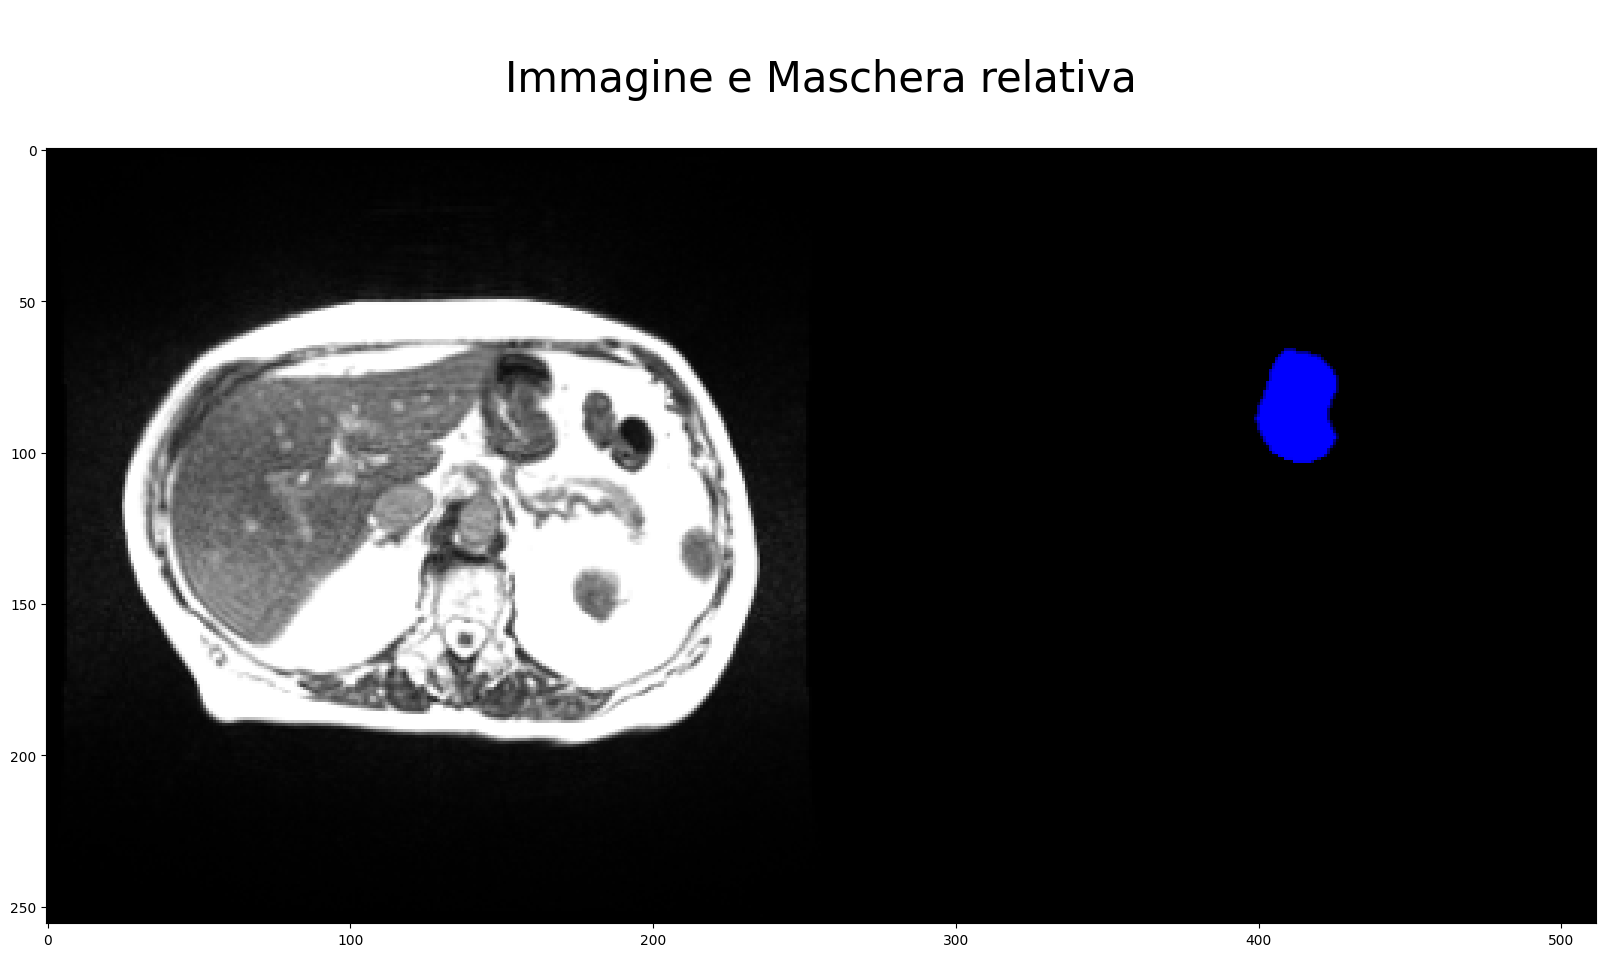

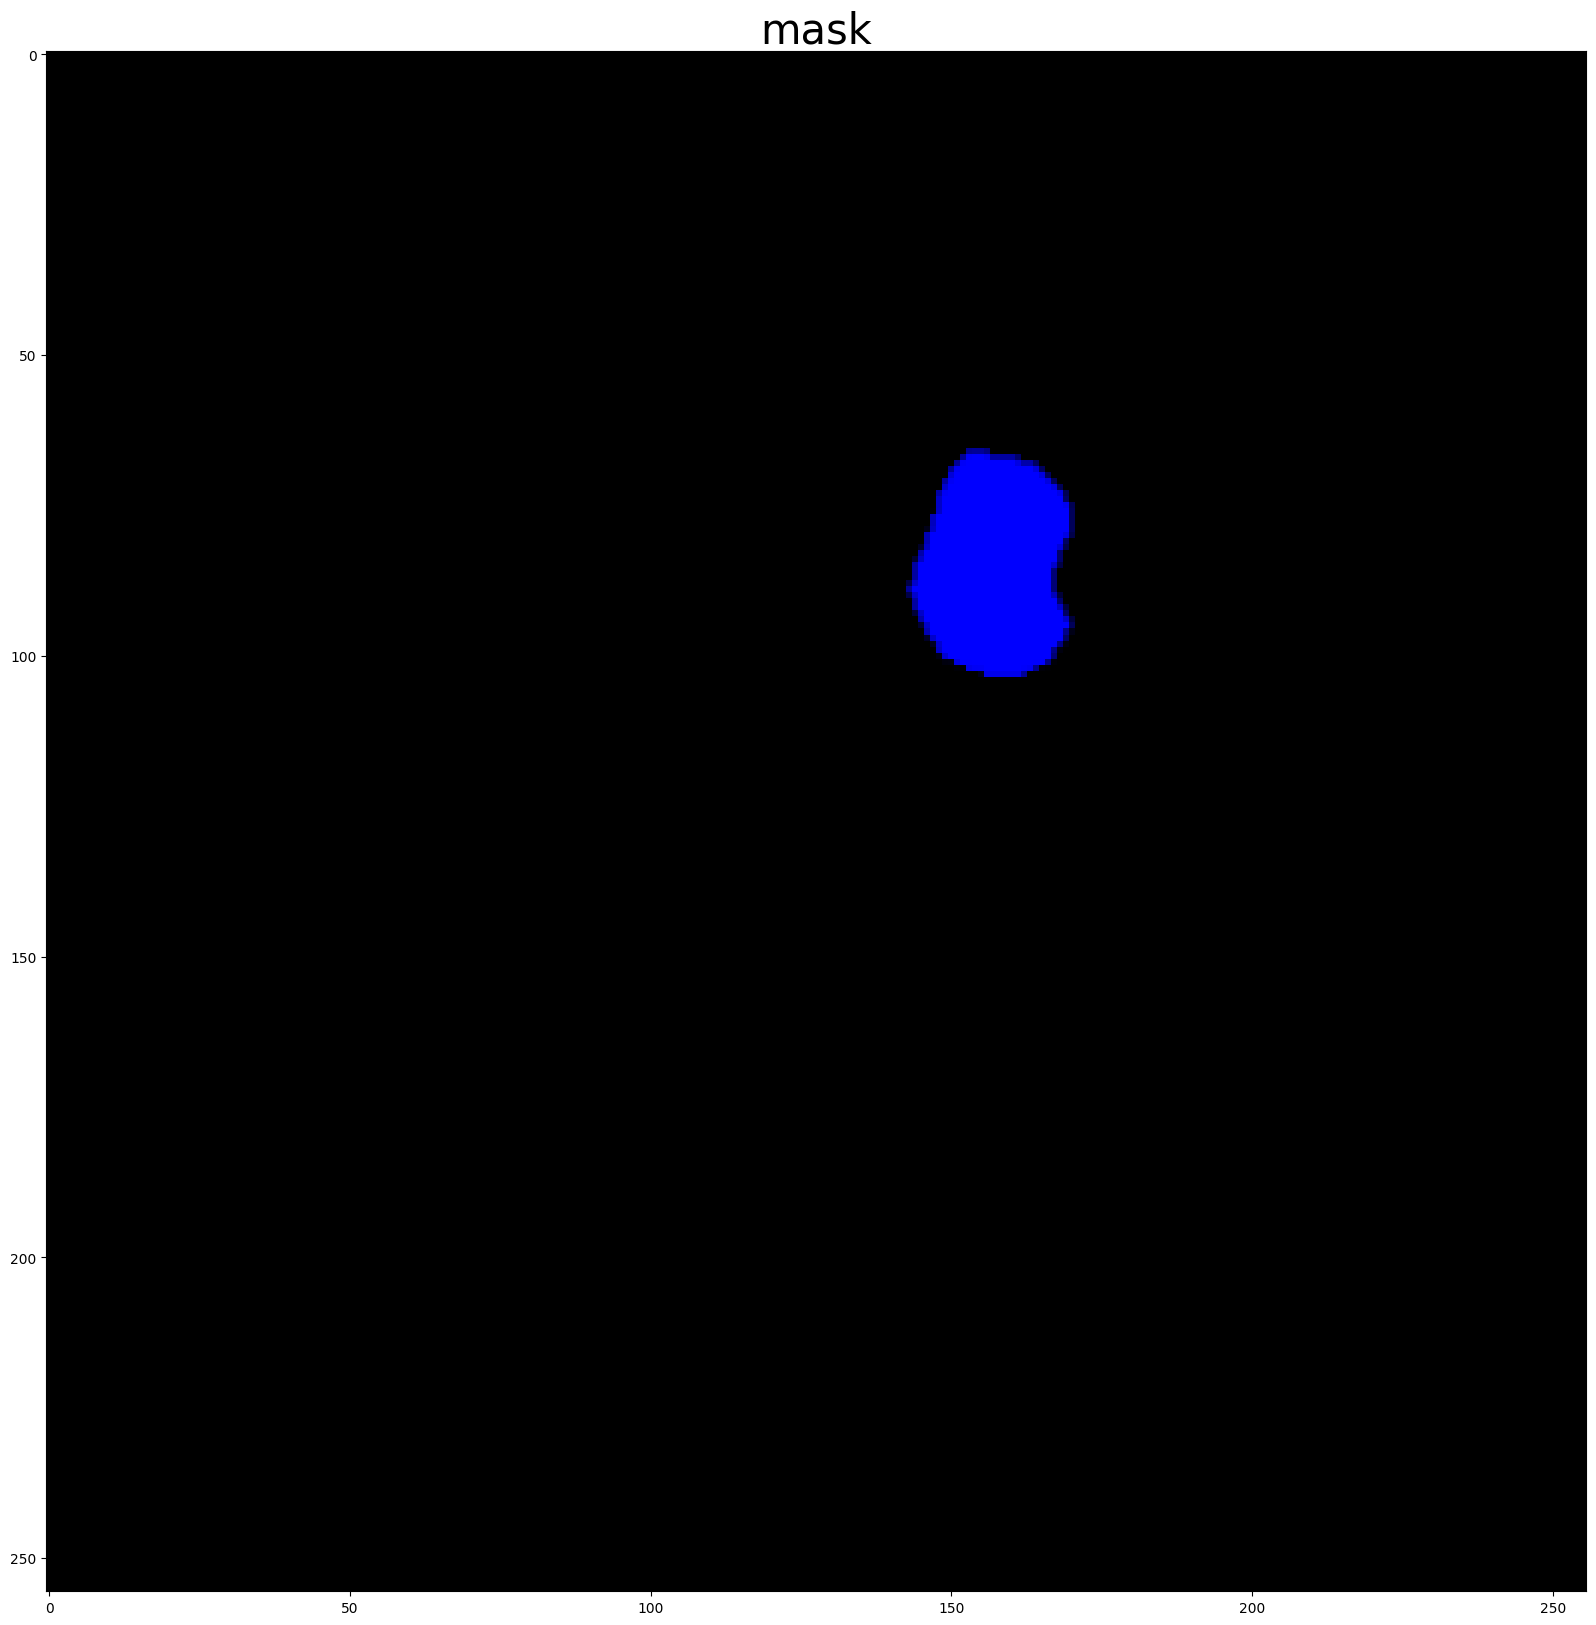

In [51]:
combined_im_mask = torch.cat([image, mask], dim=2)

def show_image(tensor_image: torch.Tensor, name: str):
    """Funzione per visualizzare un'immagine definita da un Tensor

    Args:
        tensor_image (torch.Tensor): tensore dell'immagine da mostrare
        name (str): titolo dell'immagine
    """
    plt.figure(figsize=(20, 20))
    plt.imshow(tensor_image.permute(1,2,0))
    plt.title(name, size=30)
    plt.show()

show_image(combined_im_mask, "\nImmagine e Maschera relativa\n")

show_image(mask, "mask")

Dobbiamo fare una divisione del training set per ricavare un validation set: proviamo con percentuale 90-10.

Calcoliamo la dimensione del training set e, successivamente, la sottraiamo alla lunghezza del dataset, ottenendo la dimensione del validation set.

In [52]:
train_size = int(len(ds)*0.9)

val_size = len(ds) - train_size

Sfruttando pytorch, implementiamo la divisione

In [53]:
train_ds, val_ds = torch.utils.data.random_split(ds, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))
print(f"Length of the training dataset : {len(train_ds)}")
print(f"Length of the validation dataset : {len(val_ds)}")

Length of the training dataset : 103939
Length of the validation dataset : 11549


In [54]:
def data_preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    
    df["segmentation"] = df["segmentation"].astype("str")
    
    df["case_id"] = df["id"].apply(lambda x: x.split("_")[0][4:])
    
    df["day_id"] = df["id"].apply(lambda x: x.split("_")[1][3:])
    
    df["slice_id"] = df["id"].apply(lambda x: x.split("_")[-1])
    
    return df

Da un'ispezione diretta di alcune immagini, si nota che queste sono troppo "scure" e forniscono poco contenuto in termini di informazioni. 

Pertanto, per migliorare la resa di queste immagini possiamo adottare due metodi:

* Specifica diretta dell'istogramma

* Equalizzazione dell'istogramma

**FARE ELENCO Vantaggi e svantaggi prima**

**FARE ELENCO Vantaggi e svantaggi della seconda tecnica**



Generiamo quindi una funzione ad hoc che, ricevute in input due immagini (quella da migliorare e quella da usare come riferimento), fornisce in output la specifica dell'istogramma.

In [55]:
# FUNZIONE SPECIFICA ISTOGRAMMA

import cv2 as cv

from skimage import exposure
from skimage.exposure import match_histograms

def specifica_istogramma(img_path: str, img_ref_path: str) -> Image:
    
    # lettura immagine principale
    img = cv.imread(os.path.join(img_path), 0)
    
    # lettura immagine di riferimento
    img_ref = cv.imread(os.path.join(img_ref_path), 0)
    
    matched = match_histograms(img, img_ref, channel_axis=None)
    
    return matched

No of Channel is: 2
No of Channel is: 2


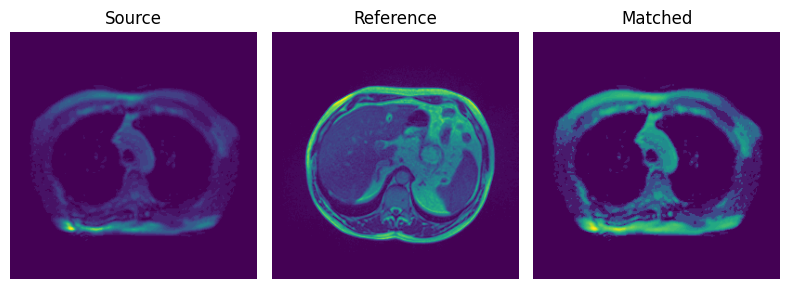

/tmp/ipykernel_38123/1868810907.py:44: RuntimeWarning: invalid value encountered in divide
  axes[c, i].plot(bins, img_hist / img_hist.max())


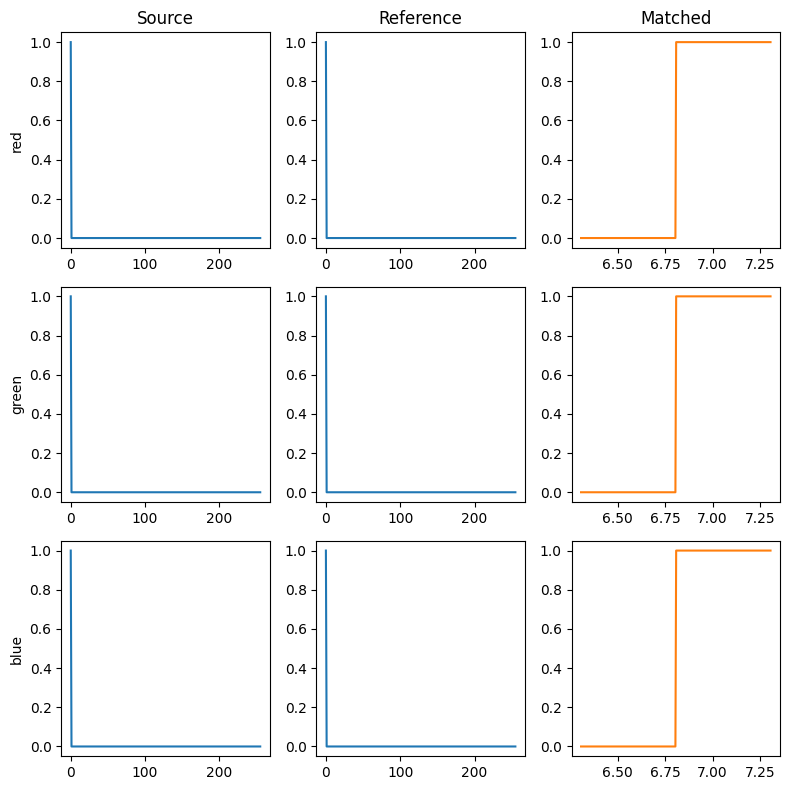

In [56]:
#####################################################################    
# CODICE ORIGINALE

# reading main image
img1 = cv.imread(os.path.join(TRAIN_DIR, "case146", "case146_day0", "scans", "slice_0003_266_266_1.50_1.50.png"), 0) 
  
# checking the number of channels
print('No of Channel is: ' + str(img1.ndim))
  
# reading reference image
img2 = cv.imread(os.path.join(TRAIN_DIR, "case35", "case35_day15", "scans", "slice_0048_276_276_1.63_1.63.png"), 0) 
  
# checking the number of channels
print('No of Channel is: ' + str(img2.ndim))
  
image = img1
reference = img2
  
matched = match_histograms(image, reference, channel_axis=None)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, 
                                    figsize=(8, 3),
                                    sharex=True, sharey=True)
  
for aa in (ax1, ax2, ax3):
    aa.set_axis_off()
  
ax1.imshow(image)
ax1.set_title('Source')
ax2.imshow(reference)
ax2.set_title('Reference')
ax3.imshow(matched)
ax3.set_title('Matched')
  
plt.tight_layout()
plt.show()
  
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))
  
for i, img in enumerate((image, reference, matched)):
    for c, c_color in enumerate(('red', 'green', 'blue')):
        img_hist, bins = exposure.histogram(img[..., c], 
                                            source_range='dtype')
        axes[c, i].plot(bins, img_hist / img_hist.max())
        img_cdf, bins = exposure.cumulative_distribution(img[..., c])
        axes[c, i].plot(bins, img_cdf)
        axes[c, 0].set_ylabel(c_color)
  
axes[0, 0].set_title('Source')
axes[0, 1].set_title('Reference')
axes[0, 2].set_title('Matched')
  
plt.tight_layout()
plt.show()

Procediamo allo stesso modo per l'equalizzazione 

In [57]:
# FUNZIONE EQUALIZZAZIONE

def hist_eq(img_path: str) -> Image:
    
    # lettura immagine principale
    img = cv.imread(img_path, 0)
    
    # equalizzazione immagine
    equ = cv.equalizeHist(img)
    
    return equ 

**FARE ESEMPIO CON IMMAGINI ACCETTABILI, TIPO**
<CENTER>"case146", "case146_day0", "scans", "slice_0003_266_266_1.50_1.50.png"</CENTER>

**E CON IMMAGINI NON ACCETTABILI, CHE ANDRANNO SCARTATE**

VOGLIAMO CONCLUDERE CHE, OTTENENDO UNA RESA PIU' O MENO SIMILE, PREFERIAMO IL PROCESSO DI EQUALIZZAZIONE ALLA SPECIFICA DELL'ISTOGRAMMA PER LE IMMAGINI ACCETTABILI, MENTRE IN **ALTRI MARKDOWN** ANDIAMO AD ANALIZZARE UNA CERTA SOGLIA CHE STABILISCE SE UN'IMMAGINE E' CONSIDERATA **ACCETTABILE** O **NON ACCETTABILE** 

## DATA CLEANING

## FEATURE SELECTION AND TRASFORMATION